# Project 1: Linear Quadratic Regulator (LQR) Design
>**Date Created**: 26 January 2024<br>
>**Course**: AEM566 - Optimal Estimation<br>
>**Author**: Benjamin Lucke<br>

In [2]:
import control as ct
import numpy as np
import pandas as pd
import scipy as sp
import sympy as smp


from matplotlib import pyplot as plt

# Problem Description
___

### Dynamical System

In many instances for spacecraft dynamics and control, one is interested in modeling the dynamics
between multiple spacecraft, e.g., a **rendezvous and proximity operation (RPO)**. To that end,
consider the following simplified model of two satellites operating in proximity, i.e. a simplified
**three-body problem**, involving a **chaser spacecraft** and a **target spacecraft** (subscript $t$) on
an elliptical orbit. One can represent this relative motion in the **Hill frame (HF)** for the target
spacecraft as shown in the following figure.

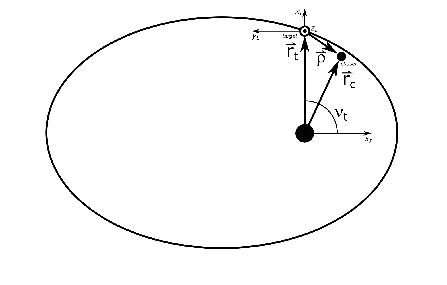

Thus, one can represent the target position relative to the celestial body in the target’s HF axes
as $$\vec{r}_t = \begin{bmatrix} r_t \\ 0 \\ 0 \end{bmatrix}$$

and the relative position of the chaser in the target's HF axes as $$\vec{\rho} = \begin{bmatrix} x \\ y \\ z\end{bmatrix}$$

Then, noting $$\vec{r}_c = \vec{r}_t + \vec{\rho}$$ 

## Problem 1

Compute the eigenvalues of the state matrix for the continuous LTI system and comment on the stability of the system.
#### Solution

Define constants

In [3]:
mu = 3.986004418 * 10**14  ## m^3s^-2
rt = 6783000  # meters
x0 = np.array([1000, 1000, 1000, 0, 0, 0])  # m
nt = np.sqrt(mu / (rt**3))

nt_symbolic = smp.Symbol("n_t")

In [4]:
A_ct_sympy = smp.Matrix(
    [
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [3 * nt_symbolic**2, 0, 0, 0, 2 * nt_symbolic, 0],
        [0, 0, 0, -2 * nt_symbolic**2, 0, 0],
        [0, 0, -(nt_symbolic**2), 0, 0, 0],
    ]
)
A_ct_numpy = np.array(
    [
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [3 * nt**2, 0, 0, 0, 2 * nt, 0],
        [0, 0, 0, -2 * nt**2, 0, 0],
        [0, 0, -(nt**2), 0, 0, 0],
    ]
)
eigs_A_symbolic = A_ct_sympy.subs(nt_symbolic, 0.01).eigenvals().keys()
vals, vecs = np.linalg.eig(A_ct_numpy)
print(eigs_A_symbolic)

dict_keys([0, -0.0172046505340853, 0.0172046505340853, -0.01*I, 0.01*I])


$r_t$ will never be less than zero, and $\mu$ is a constant greter than zero, so $n_t$ will always be greater than zero. For $n_t \geq 0$, the eigenvalues of the dynamics matrix are purely imaginary and thus the system is **marginally stable**, that is, the system will have bounded oscillations with no control input. 

### Problem 2
Compute the controllability matrix for the continuous-time LTI system.

In [5]:
B_ct_sympy = smp.Matrix(
    [[0, 0, 0], [0, 0, 0], [0, 0, 0], [1, 0, 0], [0, 1, 0], [0, 0, 1]]
)

B_ct_numpy = np.array(
    [[0, 0, 0], [0, 0, 0], [0, 0, 0], [1, 0, 0], [0, 1, 0], [0, 0, 1]]
)

ctrb = ct.ctrb(A_ct_numpy, B_ct_numpy)
print(np.linalg.matrix_rank(ctrb))

6


System is controllable since the controllability matrix is full rank.

### Problem 3

Design a finite-horizon LQR for the continuous time system with $t_f = 16200 s$.

In [421]:
t_eval = np.linspace(16200, 0, 25000)

In [480]:
def dPdt(t, P, A, B, Q, R):
    P = P.reshape((6, 6))
    dpdt = (
        -np.dot(P, A)
        - np.dot(A.T, P)
        + np.dot(P, B).dot(np.linalg.inv(R)).dot(B.T).dot(P)
        - Q
    ).flatten()
    return dpdt


def dxdt(t, x, A, B, R, P, ts):
    interp_P = sp.interpolate.interp1d(ts, P.reshape(36, -1))
    P_t = interp_P(t).reshape((6, 6))
    K_t = np.dot(np.linalg.inv(R), np.dot(B.T, P_t))
    u = -np.dot(K_t, x)
    xdot = np.dot(A - np.dot(B, K_t), x)
    return xdot


def calc_u(Ps, x, R, B, t_solve):
    u_s = np.zeros((3, t_solve.shape[0]))
    interp_P = sp.interpolate.interp1d(t_solve, Ps.reshape(36, -1))
    for k, t in enumerate(t_solve):
        P_t = interp_P(t).reshape((6, 6))
        K_t = np.dot(np.linalg.inv(R), np.dot(B.T, P_t))
        u = -np.dot(K_t, x[:, k])
        u_s[:, k] = u
    return u_s

In [ ]:
sols_P_case1 = sp.integrate.solve_ivp(
    dPdt,
    t_span=[16200, 0],
    t_eval=t_eval,
    y0=np.zeros((6, 6)).flatten(),
    args=(A_ct_numpy, B_ct_numpy, np.eye(6), np.eye(3)),
)
t_solve_case1 = np.flip(sols_P_case1.t)
P_case1 = np.flip(sols_P_case1.y.reshape((6, 6, -1)))
sols_cl_case1 = sp.integrate.solve_ivp(
    dxdt,
    t_span=[0, 16200],
    t_eval=t_solve_case1,
    y0=x0,
    args=(A_ct_numpy, B_ct_numpy, np.eye(3), P_case1, t_solve_case1),
)

In [426]:
sols_P_case2 = sp.integrate.solve_ivp(
    dPdt,
    t_span=[16200, 0],
    t_eval=t_eval,
    y0=np.zeros((6, 6)).flatten(),
    args=(A_ct_numpy, B_ct_numpy, np.eye(6), 100 * np.eye(3)),
)
t_solve_case2 = np.flip(sols_P_case2.t)
P_case2 = np.flip(sols_P_case2.y.reshape((6, 6, -1)))
sols_cl_case2 = sp.integrate.solve_ivp(
    dxdt,
    t_span=[0, 16200],
    t_eval=t_solve_case2,
    y0=x0,
    args=(A_ct_numpy, B_ct_numpy, 100 * np.eye(3), P_case2, t_solve_case2),
)

In [427]:
sols_P_case3 = sp.integrate.solve_ivp(
    dPdt,
    t_span=[16200, 0],
    t_eval=t_eval,
    y0=np.zeros((6, 6)).flatten(),
    args=(A_ct_numpy, B_ct_numpy, np.eye(6), 10000 * np.eye(3)),
)
t_solve_case3 = np.flip(sols_P_case3.t)
P_case3 = np.flip(sols_P_case3.y.reshape((6, 6, -1)))
sols_cl_case3 = sp.integrate.solve_ivp(
    dxdt,
    t_span=[0, 16200],
    t_eval=t_solve_case3,
    y0=x0,
    args=(A_ct_numpy, B_ct_numpy, 10000 * np.eye(3), P_case3, t_solve_case3),
)

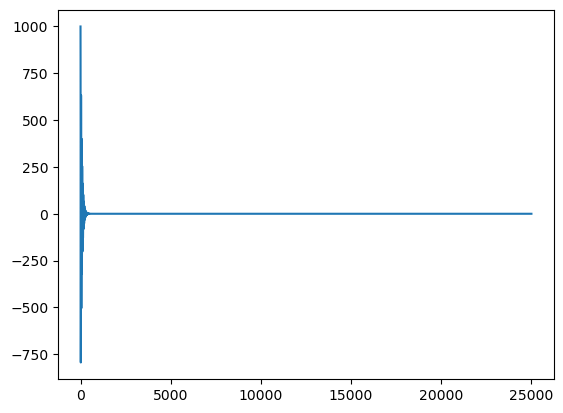

In [510]:
plt.plot(sols_cl_case2.y[2, :])

(0.0, 1000.0)

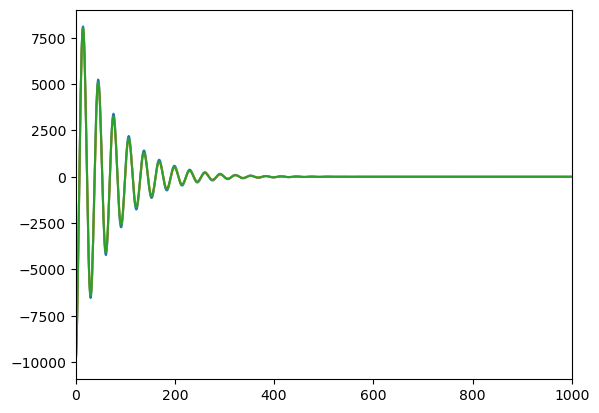

In [514]:
a = calc_u(P_case2, sols_cl_case2.y, np.eye(3), B_ct_numpy, t_solve_case2)

fig, ax = plt.subplots()
ax.plot(a[0, :])
ax.plot(a[1, :])
ax.plot(a[2, :])
ax.set_xlim((0, 1000))

In [469]:
t_solve_case3.shape[0]

25000

In [470]:
P_case1.shape

(6, 6, 25000)